<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(Adv_02).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Groverのアルゴリズム - 量子コンピュータによる高速探索

この講義では、量子アルゴリズムの代表例である「Groverのアルゴリズム」について、実装を詳しく解説します。

**学習内容:**

1.  **Groverのアルゴリズムの概要:**  従来の探索アルゴリズムとの違い、量子コンピュータで高速化が実現できる仕組みを学びます。
2.  **量子回路の設計:** Qiskit を用いて、Groverのアルゴリズムを実現する量子回路を設計します。
    *   オラクル (Oracle) の作成
    *   反復 (Diffusion) 操作の理解と実装
3.  **シミュレーションと実機実行:** 作成した量子回路を、Qiskit のシミュレータと IBM Quantum の実機で実行し、結果を検証します。


In [ ]:
!pip install qiskit qiskit-aer matplotlib
!pip install qiskit_ibm_runtime
!pip install pylatexenc

In [ ]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram, array_to_latex  # 状態ベクトルをきれいに表示
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Estimator, Session

# For plotting
import matplotlib.pyplot as plt

In [ ]:
#状態ベクトルで表示できるようにシミュレーション
#量子回路をわたして、戻り値は状態ベクトル
def Statevector_Simulator(qc):
  # AerSimulatorのインスタンスを作成
  sim = AerSimulator(method='statevector')

  # 回路をトランスパイル
  compiled_qc = transpile(qc, sim)

  # シミュレーションを実行
  res = sim.run(compiled_qc).result()
  # 状態ベクトルを取得
  state = res.get_statevector(compiled_qc)

  return state

（準備0）基本操作：重ね合わせの作成

In [ ]:
n=2
# n量子ビット, n古典ビット
qc = QuantumCircuit(n,n)

for i in range(n):
    qc.h(i)
qc.save_statevector() # 状態ベクトルを保存する命令を追加

qc.draw()

┌───┐ statevector 
q_0: ┤ H ├──────░──────
     ├───┤      ░      
q_1: ┤ H ├──────░──────
     └───┘      ░      
c: 2/══════════════════

In [ ]:
state = Statevector_Simulator(qc)
# 状態ベクトルを表示
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

（準備1）確率振幅の一部をマイナスにする操作を実装する

In [ ]:
n=2
# n量子ビット, n古典ビット
qc = QuantumCircuit(n,n)

for i in range(n):
    qc.h(i)
qc.h(1)
qc.cx(0,1)
qc.h(1)
qc.save_statevector() # 状態ベクトルを保存する命令を追加

qc.draw()

┌───┐                statevector 
q_0: ┤ H ├───────■─────────────░──────
     ├───┤┌───┐┌─┴─┐┌───┐      ░      
q_1: ┤ H ├┤ H ├┤ X ├┤ H ├──────░──────
     └───┘└───┘└───┘└───┘      ░      
c: 2/═════════════════════════════════

In [ ]:
state = Statevector_Simulator(qc)
# 状態ベクトルを表示
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

5qbitで行う

In [ ]:
n=5
# n量子ビット, n古典ビット
qc = QuantumCircuit(n,n)

for i in range(n):
    qc.h(i)

qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     └───┘
c: 5/═════

In [ ]:
N=12 #適当な数字
binN=format(N,'05b')#5桁2進数表記
print(binN)

01100


In [ ]:
for k in range(n):
  if binN[n-1-k]=='0':
    qc.x(k)

In [ ]:
qc.draw()

┌───┐┌───┐
q_0: ┤ H ├┤ X ├
     ├───┤├───┤
q_1: ┤ H ├┤ X ├
     ├───┤└───┘
q_2: ┤ H ├─────
     ├───┤     
q_3: ┤ H ├─────
     ├───┤┌───┐
q_4: ┤ H ├┤ X ├
     └───┘└───┘
c: 5/══════════

In [ ]:
qc.h(n-1)
controls = list(range(n - 1))  # 制御量子ビットのリスト [0, 1, 2, 3]
qc.mcx(controls,n-1)
qc.h(n-1)

In [ ]:
qc.draw()

┌───┐┌───┐               
q_0: ┤ H ├┤ X ├───────■───────
     ├───┤├───┤       │       
q_1: ┤ H ├┤ X ├───────■───────
     ├───┤└───┘       │       
q_2: ┤ H ├────────────■───────
     ├───┤            │       
q_3: ┤ H ├────────────■───────
     ├───┤┌───┐┌───┐┌─┴─┐┌───┐
q_4: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘
c: 5/═════════════════════════

In [ ]:
for k in range(n):
  if binN[n-1-k]=='0':
    qc.x(k)

In [ ]:
qc.save_statevector() # 状態ベクトルを保存する命令を追加

In [ ]:
qc.draw()

┌───┐┌───┐          ┌───┐      statevector 
q_0: ┤ H ├┤ X ├───────■──┤ X ├───────────░──────
     ├───┤├───┤       │  ├───┤           ░      
q_1: ┤ H ├┤ X ├───────■──┤ X ├───────────░──────
     ├───┤└───┘       │  └───┘           ░      
q_2: ┤ H ├────────────■──────────────────░──────
     ├───┤            │                  ░      
q_3: ┤ H ├────────────■──────────────────░──────
     ├───┤┌───┐┌───┐┌─┴─┐┌───┐┌───┐      ░      
q_4: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├──────░──────
     └───┘└───┘└───┘└───┘└───┘└───┘      ░      
c: 5/═══════════════════════════════════════════

In [ ]:
state = Statevector_Simulator(qc)

In [ ]:
#13番目(N=12)の確率振幅が-1掛けられている
print(state)

Statevector([ 0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
             -0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j],
            dims=(2, 2, 2, 2, 2))


In [ ]:
print(state[N])

(-0.1767766952966368+0j)


任意のqbitに一般化

In [ ]:
#Oracle（正解を知っている神）
def oracle(N,n):
  binN=format(N,'05b')

  qc = QuantumCircuit(n)

  for k in range(n):
    if binN[n-1-k]=='0':
      qc.x(k)
  qc.h(n-1)
  controls = list(range(n - 1))  # 制御量子ビットのリスト
  qc.mcx(controls,n-1)

  qc.h(n-1)
  for k in range(n):
    if binN[n-1-k]=='0':
      qc.x(k)

  Oracle = qc.to_gate()
  Oracle.name = "Oracle"
  return Oracle

In [ ]:
n = 5
N = 25 #任意の番号 (< 2^n-1)
qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i)

qc.draw()

Oracle = oracle(N,n)
qc.append(Oracle,list(range(n)))

qc.draw()


┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│         │
q_1: ┤ H ├┤1        ├
     ├───┤│         │
q_2: ┤ H ├┤2 Oracle ├
     ├───┤│         │
q_3: ┤ H ├┤3        ├
     ├───┤│         │
q_4: ┤ H ├┤4        ├
     └───┘└─────────┘

In [ ]:
qc.save_statevector() # 状態ベクトルを保存する命令を追加
state = Statevector_Simulator(qc)

In [ ]:
state

Statevector([ 0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767-2.16489014e-17j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767+2.16489014e-17j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000

In [ ]:
print(state[N])

(-0.17677669529663684+2.164890140588733e-17j)


（準備2）次は、（確率振幅に-1を掛けた）選択した状態を取り出す仕組みについて

In [ ]:
def hadamard_all(qc,n):
  for i in range(n):
   qc.h(i)

def xgate_all(qc,n):
  for i in range(n):
    qc.x(i)

In [ ]:
n=2
qc = QuantumCircuit(n)
hadamard_all(qc,n)
qc.cz(0,1)
hadamard_all(qc,n)
qc.save_statevector() # 状態ベクトルを保存する命令を追加
qc.draw()

┌───┐   ┌───┐ statevector 
q_0: ┤ H ├─■─┤ H ├──────░──────
     ├───┤ │ ├───┤      ░      
q_1: ┤ H ├─■─┤ H ├──────░──────
     └───┘   └───┘      ░

In [ ]:
state = Statevector_Simulator(qc)
# 状態ベクトルを表示
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

In [ ]:
n=2
qc = QuantumCircuit(n)
hadamard_all(qc,n)
qc.cz(0,1)
hadamard_all(qc,n)

 #ここから下を追加
xgate_all(qc,n)
qc.cz(0,1)
xgate_all(qc,n)
qc.save_statevector() # 状態ベクトルを保存する命令を追加
qc.draw()

┌───┐   ┌───┐┌───┐   ┌───┐ statevector 
q_0: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├──────░──────
     ├───┤ │ ├───┤├───┤ │ ├───┤      ░      
q_1: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├──────░──────
     └───┘   └───┘└───┘   └───┘      ░

In [ ]:
state = Statevector_Simulator(qc)
# 状態ベクトルを表示
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

In [ ]:
n=2
qc = QuantumCircuit(n)
hadamard_all(qc,n)
qc.cz(0,1)
hadamard_all(qc,n)

xgate_all(qc,n)
qc.cz(0,1)
xgate_all(qc,n)

hadamard_all(qc,n) #<----ここを追加
qc.save_statevector() # 状態ベクトルを保存する命令を追加

qc.draw()

┌───┐   ┌───┐┌───┐   ┌───┐┌───┐ statevector 
q_0: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├┤ H ├──────░──────
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤      ░      
q_1: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├┤ H ├──────░──────
     └───┘   └───┘└───┘   └───┘└───┘      ░

In [ ]:
state = Statevector_Simulator(qc)
# 状態ベクトルを表示
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

これは、最後の状態ベクトルの確率振幅のみゼロではない＝状態ベクトルを取り出せる

In [ ]:
def diffusion(n):
  qc = QuantumCircuit(n)
  hadamard_all(qc,n)
  xgate_all(qc,n)


  qc.h(n-1)
  controls = list(range(n - 1))
  qc.mcx(controls,n-1)
  qc.h(n-1)

  xgate_all(qc,n)

  hadamard_all(qc,n)

  Diff = qc.to_gate()
  Diff.name = "Diff"

  return Diff

In [ ]:
n = 5
N = 25

qc = QuantumCircuit(n,n)
hadamard_all(qc,n)

Oracle = oracle(N,n)
diff = diffusion(n)

Tall = 4

for k in range(Tall):
  qc.append(Oracle,list(range(n)))
  qc.append(diff,list(range(n)))

qc.save_statevector() # 状態ベクトルを保存する命令を追加
qc.draw()

┌───┐┌─────────┐┌───────┐┌─────────┐┌───────┐┌─────────┐┌───────┐»
q_0: ┤ H ├┤0        ├┤0      ├┤0        ├┤0      ├┤0        ├┤0      ├»
     ├───┤│         ││       ││         ││       ││         ││       │»
q_1: ┤ H ├┤1        ├┤1      ├┤1        ├┤1      ├┤1        ├┤1      ├»
     ├───┤│         ││       ││         ││       ││         ││       │»
q_2: ┤ H ├┤2 Oracle ├┤2 Diff ├┤2 Oracle ├┤2 Diff ├┤2 Oracle ├┤2 Diff ├»
     ├───┤│         ││       ││         ││       ││         ││       │»
q_3: ┤ H ├┤3        ├┤3      ├┤3        ├┤3      ├┤3        ├┤3      ├»
     ├───┤│         ││       ││         ││       ││         ││       │»
q_4: ┤ H ├┤4        ├┤4      ├┤4        ├┤4      ├┤4        ├┤4      ├»
     └───┘└─────────┘└───────┘└─────────┘└───────┘└─────────┘└───────┘»
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«     ┌─────────┐┌───────┐ statevector 
«q_0: ┤0        ├┤0      ├──────░──────
«     │         ││       │      ░      
«q_1: ┤1        ├┤1      ├──────░──────
«     │         ││       │      ░      
«q_2: ┤2 Oracle ├┤2 Diff ├──────░──────
«     │         ││       │      ░      
«q_3: ┤3        ├┤3      ├──────░──────
«     │         ││       │      ░      
«q_4: ┤4        ├┤4      ├──────░──────
«     └─────────┘└───────┘      ░      
«c: 5/═════════════════════════════════
«

In [ ]:
state = Statevector_Simulator(qc)
array_to_latex(state, prefix="state = ")

<IPython.core.display.Latex object>

<ipython-input-120-a5777c18ac35>:1: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  squared_state = [s**2 for s in state]
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


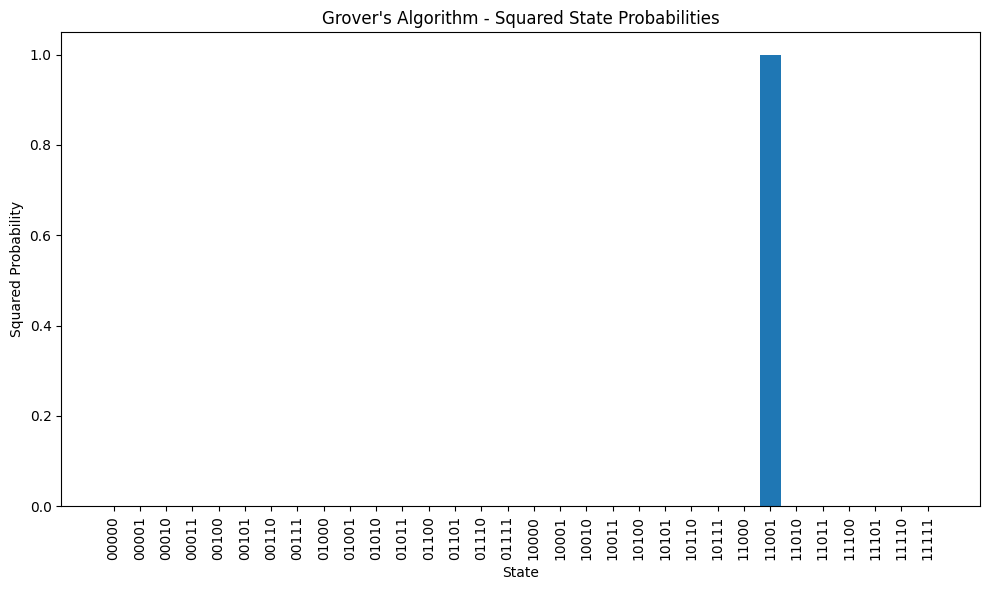

In [ ]:
squared_state = [s**2 for s in state]

plt.figure(figsize=(10, 6)) # 図のサイズを調整
plt.bar(range(2**n), squared_state)
plt.xlabel("State")
plt.ylabel("Squared Probability")  # Y軸ラベルを修正
plt.title("Grover's Algorithm - Squared State Probabilities")
plt.xticks(range(2**n), [format(i, '0{}b'.format(n)) for i in range(2**n)], rotation=90) # X軸のラベルを修正
plt.tight_layout()
plt.show()

In [ ]:
n = 5
N = 25

qc = QuantumCircuit(n,n)
hadamard_all(qc,n)

Oracle = oracle(N,n)
diff = diffusion(n)

Tall = 4

for k in range(Tall):
  qc.append(Oracle,list(range(n)))
  qc.append(diff,list(range(n)))

qc.measure_all()
qc.draw()

┌───┐┌─────────┐┌───────┐┌─────────┐┌───────┐┌─────────┐┌───────┐»
   q_0: ┤ H ├┤0        ├┤0      ├┤0        ├┤0      ├┤0        ├┤0      ├»
        ├───┤│         ││       ││         ││       ││         ││       │»
   q_1: ┤ H ├┤1        ├┤1      ├┤1        ├┤1      ├┤1        ├┤1      ├»
        ├───┤│         ││       ││         ││       ││         ││       │»
   q_2: ┤ H ├┤2 Oracle ├┤2 Diff ├┤2 Oracle ├┤2 Diff ├┤2 Oracle ├┤2 Diff ├»
        ├───┤│         ││       ││         ││       ││         ││       │»
   q_3: ┤ H ├┤3        ├┤3      ├┤3        ├┤3      ├┤3        ├┤3      ├»
        ├───┤│         ││       ││         ││       ││         ││       │»
   q_4: ┤ H ├┤4        ├┤4      ├┤4        ├┤4      ├┤4        ├┤4      ├»
        └───┘└─────────┘└───────┘└─────────┘└───────┘└─────────┘└───────┘»
   c: 5/═════════════════════════════════════════════════════════════════»
                                                                         »
meas: 5/═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌─────────┐┌───────┐ ░ ┌─┐            
«   q_0: ┤0        ├┤0      ├─░─┤M├────────────
«        │         ││       │ ░ └╥┘┌─┐         
«   q_1: ┤1        ├┤1      ├─░──╫─┤M├─────────
«        │         ││       │ ░  ║ └╥┘┌─┐      
«   q_2: ┤2 Oracle ├┤2 Diff ├─░──╫──╫─┤M├──────
«        │         ││       │ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤3        ├┤3      ├─░──╫──╫──╫─┤M├───
«        │         ││       │ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤4        ├┤4      ├─░──╫──╫──╫──╫─┤M├
«        └─────────┘└───────┘ ░  ║  ║  ║  ║ └╥┘
«   c: 5/════════════════════════╬══╬══╬══╬══╬═
«                                ║  ║  ║  ║  ║ 
«meas: 5/════════════════════════╩══╩══╩══╩══╩═
«                                0  1  2  3  4

In [ ]:
from qiskit_aer import Aer
backend = Aer.get_backend('qasm_simulator')
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)
# transpiled_circuit.draw('mpl')
# Execute using the Sampler primitive
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_circuit], shots=1024)

In [ ]:
pub_result = job.result()[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

Counts for the meas output register: {'11001': 1024}


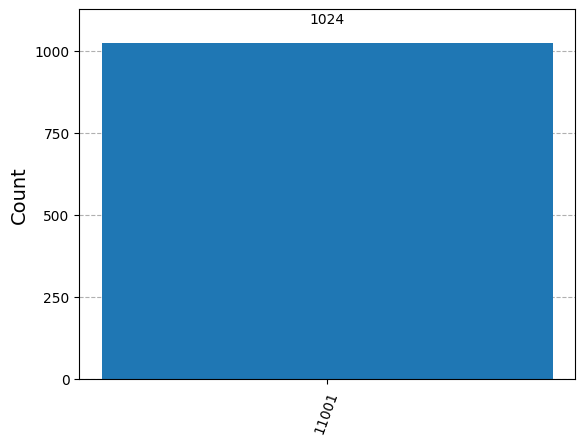

In [ ]:
# Display the histogram
plot_histogram(pub_result.data.meas.get_counts())

In [ ]:
# print(state[N])

IBMの実機に投入してみよう

In [ ]:
from google.colab import userdata
ibm_token = userdata.get('ibm_token')

# To run on hardware, select the backend with the fewest number of jobs in the queue
# Authenticate to IBM Quantum account
QiskitRuntimeService.save_account(
    ibm_token,
    channel='ibm_quantum', overwrite=True  # Specify the channel here
)
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

Running on backend: ibm_brisbane


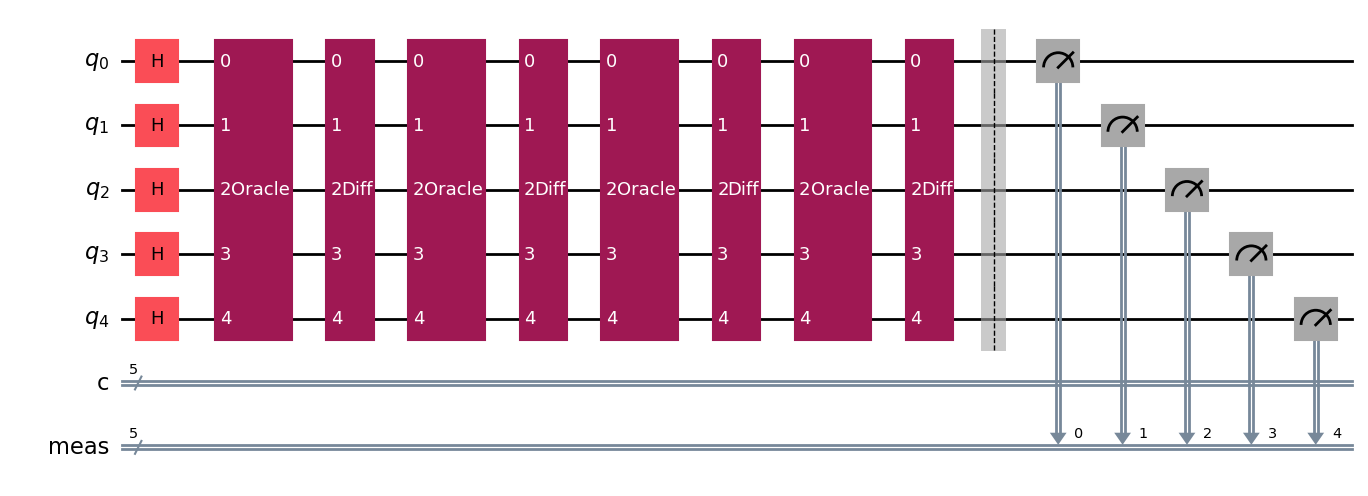

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
from qiskit.visualization import array_to_latex, plot_histogram
import matplotlib.pyplot as plt

# IBM Quantum アカウントへの接続設定
service = QiskitRuntimeService(channel='ibm_quantum')

# 使用するバックエンド (実機) を選択 (ここを変更)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=5) # 5qubit以上を指定

print(f"Running on backend: {backend.name}")

# 実行したい量子回路を生成（既存のコードを使用）
#例題
n = 5
N = 25

qc = QuantumCircuit(n, n)  # 測定用の古典ビットを追加
hadamard_all(qc,n)

Oracle = oracle(N,n)
diff = diffusion(n)

Tall = 4

for k in range(Tall):
  qc.append(Oracle,list(range(n)))
  qc.append(diff,list(range(n)))

# 測定を追加
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")


In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

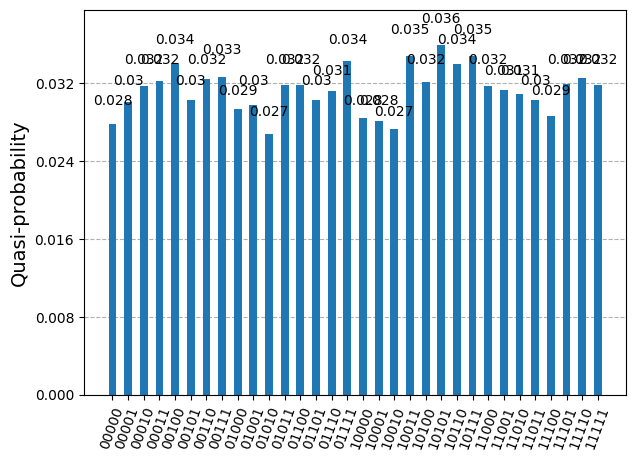

In [ ]:
plot_distribution(dist)

現在、量子コンピュータの実機はまだ発展途上にあり、動作に多くの誤差を含んでいます。しかし、「誤差が多いから今はまだ学習しても無駄だ」と考えるのは正しくありません。Qiskit のシミュレータを活用すれば、実機に依存しないアルゴリズム開発を進めることができますし、IBM Quantum を通じて手軽に実機を試すこともできます。重要なのは、近い将来、本格的に実用化される量子コンピュータが登場した際に、すぐにその技術を活用できるよう、今のうちから準備しておくことです。シミュレーションと実機実験の両方を通じて、量子コンピューティングの基礎と応用を学び、来るべき時代に備えましょう。